In [1]:
import network as nw
import numpy as np 
from scipy.sparse import csr_matrix
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#collecting data from csv file
data = np.genfromtxt("connections.csv", delimiter=",")
#matrix dimension
N = int(np.max(data)) + 1
#generating the sparse matrix from data
A = csr_matrix((np.ones(len(data)), (data[:, 0], data[:, 1])), shape = (N, N), dtype = np.int32)
#making the network undirected
A = A + A.T
#removing multilinks
#A = 1*(A > 0)

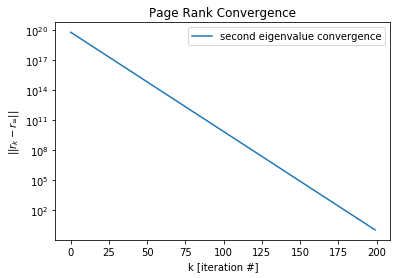

In [3]:
#I want an error that is around 1e-15 so i check the convergence of power iteration
#to find out the number of iterations needed
d = 1 / nw.get_degrees(A)
M = A * sp.sparse.diags(d[:, 0])
v = nw.get_two_highest_eigenvalues(M)
v2 = v[1]

plt.title("Page Rank Convergence")
ind = np.arange(200)
ref = (0.85*np.abs(v2))**ind
plt.semilogy(ind, ref/ref[-1])
plt.xlabel("k [iteration #]")
plt.ylabel(r"$||r_k - r_\infty||$")
plt.legend(["second eigenvalue convergence"])


In [4]:
#from the previous graph the error is reduced by a factor o 1e15 
#after more or less 125 iterations
num_iter = 125
p = nw.page_rank_power_iteration(A, iter_num = num_iter)

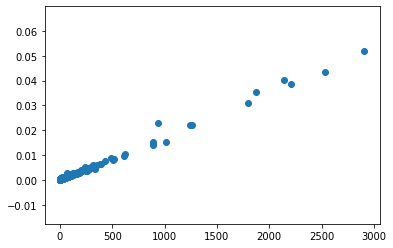

In [5]:
d = nw.get_degrees(A)
plt.scatter(d, p)

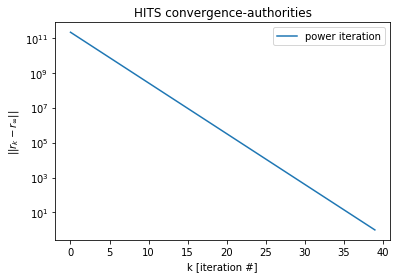

In [6]:
#I want an error that is around 1e-15 so i check the convergence of power iteration
#to find out the number of iterations needed
v = nw.get_two_highest_eigenvalues(A*A.T)

plt.figure()
plt.title("HITS convergence-authorities")
ind = np.arange(40)
ref = np.abs(v[1]/v[0])**ind
plt.semilogy(ind, ref/ref[-1])
plt.xlabel("k [iteration #]")
plt.ylabel(r"$||r_k - r_\infty||$")
plt.legend(["power iteration", "second eigenvalue"])


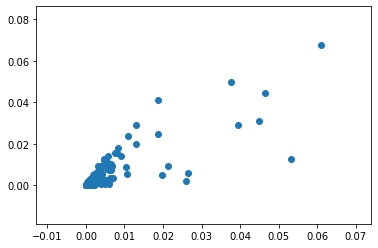

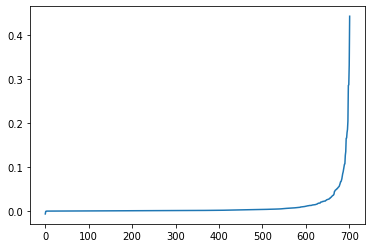

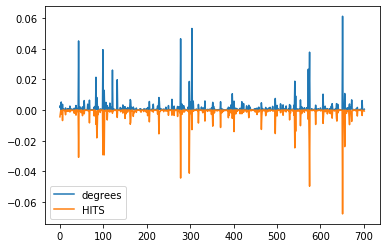

In [7]:
#i see that 40 iterations reduce the error by a reasonable amount
num_iter = 40

r = nw.hits_power_iteration(A, iter_num=num_iter)
d = d/np.sum(d)
plt.scatter(d, r/np.sum(r))
plt.figure()
plt.plot(np.sort(r-p, axis=0))
plt.figure()
plt.plot(d)
plt.plot(-r/np.sum(r))
plt.legend(["degrees", "HITS"])

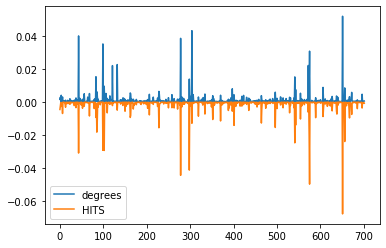

In [8]:
plt.plot(p)
plt.plot(-r/np.sum(r))
plt.legend(["degrees", "HITS"])

In [9]:
#array that contains the name of each character so it's index is it's id
characters_id = []

#reading from file
with open("nodes.csv", "r") as fp:
    for line in fp:
        #for each line get name and id
        name, name_ID = line.replace("\n", "").split(",")
        characters_id.append(name)

In [10]:
#index that would sort from less ranked to most ranked with hits and normal degrees
ids_r = np.argsort(r, axis = 0)
ids_d = np.argsort(d, axis = 0)

#ranking based on the rank difference obtained with the two ranking methods
ids_rd = np.argsort(r-d, axis = 0)

#positions in the ranking the one with the highest rank is assigned position 0
positions = np.arange(N)[::-1]

#getting the position of each character with both rankings
position_d = positions[np.argsort(ids_d, axis = 0)]
position_r = positions[np.argsort(ids_r, axis = 0)]

#points = position
#scores = 
#increment in position with HITS rank compared with the other
delta_pos = position_d - position_r
ids_delta = np.argsort(delta_pos, axis = 0)
characters_r = [characters_id[i[0]] for i in ids_r[::-1]]
characters_d = [characters_id[i[0]] for i in ids_d[::-1]]
characters_rd = [characters_id[i[0]] for i in ids_delta[::-1]]
pos_d = [position_d[i[0]][0] for i in ids_delta[::-1]]
pos_r = [position_r[i[0]][0] for i in ids_delta[::-1]]
pd_dict = {
    "HITS":characters_r, 
    "deg":characters_d
}
pd_imp_dict = {
    "character_improvement":characters_rd,
    "improvement": np.sort(delta_pos, axis = 0)[::-1,0],
    "d_pos": pos_d,
    "r_pos": pos_r

}
df = pd.DataFrame(pd_dict)
df_imp = pd.DataFrame(pd_imp_dict)

In [11]:
df_imp[(df_imp["r_pos"] < 10) | (df_imp["d_pos"] < 10)]

,character_improvement,improvement,d_pos,r_pos
365,Cersei Lannister,8,13,5
366,Joffrey Baratheon,8,11,3
371,Tywin Lannister,6,14,8
376,Sansa Stark,4,5,1
378,Sandor Clegane,3,12,9
381,Robb Stark,3,10,7
389,Tyrion Lannister,0,0,0
393,Jaime Lannister,0,2,2
399,Arya Stark,-1,3,4
402,Catelyn Stark,-2,4,6


In [12]:
df.head()

,HITS,deg
0,Tyrion Lannister,Tyrion Lannister
1,Sansa Stark,Jon Snow
2,Jaime Lannister,Jaime Lannister
3,Joffrey Baratheon,Arya Stark
4,Arya Stark,Catelyn Stark


In [26]:
f = nw.spectral_clustering_reordering
communities, separators = nw.divide_in_communities(A, f, conductance_lim=0.4)

In [27]:
def print_community(community, character_id):
    print([character_id[idx] for idx in community])
print(len(communities))

11


In [39]:
i = 10
print(f'community index = {communities[i]["path"]}')
print(f"community")
chara = communities[i]["indexes"]
chara.sort()
print_community(chara, characters_id)
print(f"borderline character = {characters_id[communities[i]['border']]}")

community index = 11
community
['Alysanne', 'Beth', 'Brandon Stark', 'Danny Flint', 'Farlen', 'Gage', 'Hodor', 'Hother Whoresbane', 'Jojen Reed', 'Knott', 'Liddle', 'Maester Luwin', 'Meera Reed', 'Mikken', 'Mors Crowfood', 'Nan', 'Osha', 'Palla', 'Septon Chayle', 'Sherrit', 'Symeon Star-Eyes', 'Theo Wull', 'Walders']
borderline character = Gage


In [16]:
def get_sep_tree(separators, path=""):
    if len(separators) == 3:
        print(f"{characters_id[separators[1]]}, path:{path}")
        get_sep_tree(separators[0] ,path+"0")
        get_sep_tree(separators[2], path+"1")
    elif len(separators) == 1:
        print(f"{characters_id[separators[0]]}, path:{path}")
    elif len(separators) == 2 and type(separators[0]) == np.int64:
        print(f"{characters_id[separators[0]]}, path:{path}")
        get_sep_tree(separators[1], path+"1")
    else:
        print(f"{characters_id[separators[1]]}, path:{path}")
        get_sep_tree(separators[0], path+"0")
get_sep_tree(separators)

Beth, path:
Rhaella, path:0
Victarion, path:00
Cortnay Penrose, path:000
Marianne, path:001
Raymun Darry, path:0010
Gage, path:1
Alliser Thorne, path:10
